### Design Problem



Reynolds number:	 67888.37612059906

Num series:		 7 
num parallel:		 4

-------------These are the table Values-------------
Height			 0.11345 	(m)
Length 			 0.19444999999999998 	(m)
Voltage of Pack		 28.0 			Volts
I of cell		 56.25 			Amps
Power Density		 4070993.663350305 	W/m^3
VDot of air		 0.01458375 		m^3/s
Pressure Drop		 6499.042274925521 	Pa
output air temp		 39.45816017540323 	C
battery temp		 75.44514211146901 	C


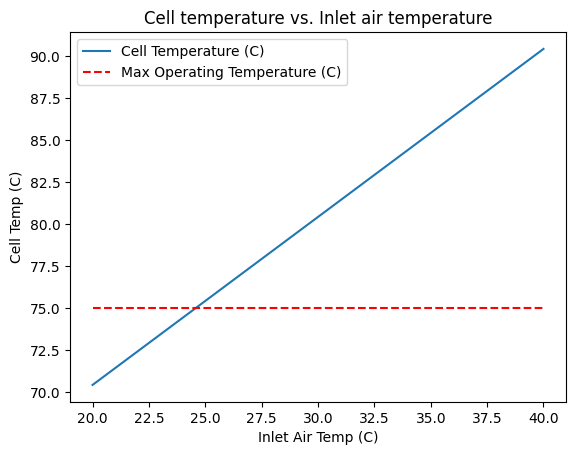

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# battery specifications
diameterBattery = 21.55/1000  # mm ->m
lengthBattery = 70.15/1000  # mm -> m
massBattery = 70/1000  # g -> kg
voltageBattery = 4.0  # V
resistanceBattery = .015  # Ω (ohms)

batteryArea = (np.pi*diameterBattery**2/2) + \
    (np.pi*diameterBattery*lengthBattery)


safeOpCurr = 45  # amps
safeOpTemp = 75  # C

# problem requirements
reqAmps = 225  # amps
reqVolts = 28  # volts

# fan specifications
fanDia = 140/1000  # mm -> m
flowRate = 270/3600  # m^3/h -> m^3/s
staticGagePressure = 65  # Pa

# other specifications
# properties of air pg 935
airTemp = 25  # C
p = 1.217  # kg/m^3 #density
cp = 1007  # J/KgK
v = 14.82e-6  # m^2/s
k = 26.3e-3  # W/mK
Pr = .707

# ----------------Chosen Variables--------------
# number and type of batteries
numSeries = 7  # reqVolts/voltageBattery
numParellel = 4  # reqAmps/safeOpCurr  # fixed

# battery spacing
sL = 27/1000  # mm ->m
sT = 27/1000  # mm ->m
sD = sT

# -----calculated values-----
totalNumBatteries = numSeries * numParellel

# power
arrVoltage = voltageBattery*numSeries  # volts
arrCurrent = reqAmps  # amps
arrPower = arrVoltage*arrCurrent  # W
arrHeatGen = arrVoltage**2 / (resistanceBattery*totalNumBatteries)

currentBattery = reqAmps/numParellel
power_heatBattery = (currentBattery**2) * \
    resistanceBattery  # watts this is also heat

# box dimensions
# spacing
minCell_WallSpace = sT - diameterBattery
height = (2*minCell_WallSpace) + (diameterBattery *
                                  numParellel) + (minCell_WallSpace*(numParellel-1))
width = lengthBattery
length = (2*minCell_WallSpace) + \
    (diameterBattery * numSeries) + (minCell_WallSpace*(numSeries-1))


def findPowerDensity():
    volPowerDensity = arrPower/(length*width*height)
    return volPowerDensity


def findU():
    area = height*width
    u = flowRate/area
    return u


# pressure drop
def findUMax():
    '''#### Based on eq 7.60
    '''
    uMax = (sT/(sT-diameterBattery))*findU()  # m/s
    return uMax


def findRe():
    Re = (diameterBattery*findUMax()) / v
    return Re


def findPressureDrop():
    # we looked up these values in the table 7.14
    x = 1  # correction factor
    f = .7  # friction factor
    NL = numSeries

    PT = sT/diameterBattery
    PL = sL/diameterBattery
    ratioPTPL = PT/PL

    deltaP = NL*x * ((p*findUMax()**2) / 2)*f
    return deltaP


def findBatteryTemp(Tinf=25):
    # from table 7.2 from the Re
    # pg 444
    Re = findRe()
    C = .027
    m = .805

    NuD = C*Re**m*Pr**(1/3)  # eq 7.52
    h = NuD*(k/diameterBattery)

    q = power_heatBattery
    Ts = (q/(h*batteryArea)) + Tinf
    return Ts


def findVDotAir():
    return (width*height*length) * findU()


def findNextAirTemp(Tprev=25):
    # gets q generated by the col of batteries
    qBatteryColumn = power_heatBattery*numParellel

    areaAir = (width*height)
    massAir = areaAir*p*findU()

    Tout_air = (qBatteryColumn / (massAir*cp)) + Tprev
    return Tout_air


def findTempsPack(T0=airTemp):
    '''
    This will iterate through the colums of batteries that we have 
    and update that cols battery temp and resultant air temp based on the previosu temp
    '''
    Tair_prev = T0
    for _ in range(int(numSeries)):  # go through cols
        batteryTemp = findBatteryTemp(Tair_prev)
        Tair_prev = findNextAirTemp(Tair_prev)
    return batteryTemp, Tair_prev


def plot():
    inletAirTemps = np.linspace(20, 40, (40-20)+1)
    batteryTemps = []
    maxTemp = []
    for temp in inletAirTemps:
        batteryTemps.append(findTempsPack(temp)[0])
        maxTemp.append(safeOpTemp)

    # Create a line plot
    plt.plot(inletAirTemps, batteryTemps, label='Cell Temperature (C)')
    plt.plot(inletAirTemps, maxTemp, linestyle='--',
             color='r', label='Max Operating Temperature (C)')

    # Add labels and a title
    plt.xlabel('Inlet Air Temp (C)')
    plt.ylabel('Cell Temp (C)')
    plt.title('Cell temperature vs. Inlet air temperature')

    # Add a legend
    plt.legend()

    # save the figure
    plt.savefig('plot.png')

    # Display the plot
    plt.show()


print()

print("Reynolds number:\t", findRe())
print("\nNum series:\t\t", numSeries, "\nnum parallel:\t\t",  numParellel)

print("\n-------------These are the table Values-------------")
print("Height\t\t\t", height, "\t(m)\nLength \t\t\t", length, "\t(m)")
print("Voltage of Pack\t\t", arrVoltage,
      "\t\t\tVolts\nI of cell\t\t", currentBattery, "\t\t\tAmps")
print("Power Density\t\t", findPowerDensity(), "\tW/m^3")
print("VDot of air\t\t", findVDotAir(), "\t\tm^3/s")
print("Pressure Drop\t\t", findPressureDrop(), "\tPa")
t = findTempsPack()
print("output air temp\t\t", t[1], "\tC\nbattery temp\t\t", t[0], "\tC")
plot()